In [2]:
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import torch
from transformers import AutoImageProcessor, ZoeDepthForDepthEstimation
import numpy as np
import open3d as o3d
import cv2 as cv

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
image_processor = AutoImageProcessor.from_pretrained("Intel/zoedepth-nyu-kitti", use_fast=True)
model = ZoeDepthForDepthEstimation.from_pretrained("Intel/zoedepth-nyu-kitti")

In [5]:
img1 = Image.open("../data/b1.jpg")
img2 = Image.open("../data/b3.jpg")

In [6]:
inputs = image_processor(images=[img1, img2], return_tensors='pt')

In [7]:
with torch.no_grad():
    outputs = model(**inputs)

In [8]:
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    source_sizes=[(img1.height, img1.width), (img2.height, img2.width)],
)

pred_depth1 = post_processed_output[0]["predicted_depth"]
depth1 = pred_depth1 * 255 / pred_depth1.max()
depth1 = depth1.detach().cpu().numpy()
depth1 = depth1.astype("uint8")

pred_depth2 = post_processed_output[1]["predicted_depth"]
depth2 = pred_depth2 * 255 / pred_depth2.max()
depth2 = depth2.detach().cpu().numpy()
depth2 = depth2.astype("uint8")

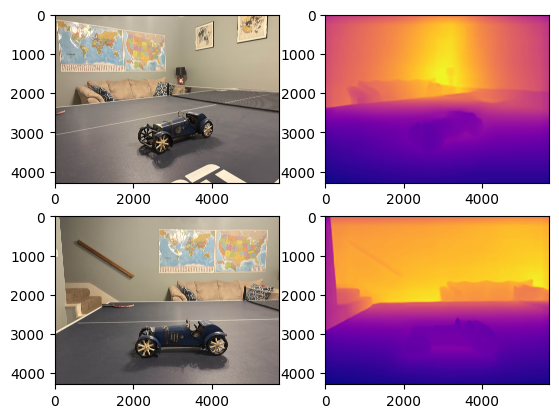

In [7]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img1)
ax[0, 1].imshow(depth1, cmap="plasma")
ax[1, 0].imshow(img2)
ax[1, 1].imshow(depth2, cmap="plasma")

In [9]:
def make_pcd(image, depth):
    w, h = image.size
    # depth_image = (output * 255 / np.max(output)).astype('uint8')

    depth_o3d = o3d.geometry.Image(depth)
    image_o3d = o3d.geometry.Image(np.array(image))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)

    cam_intrinsic = o3d.camera.PinholeCameraIntrinsic()
    cam_intrinsic.set_intrinsics(w, h, 4000, 4000, w/2, h/2)

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, cam_intrinsic)
    return pcd

In [25]:
pcd1 = make_pcd(img1, depth1)
o3d.visualization.draw_geometries([pcd1])

In [73]:
pcd2 = make_pcd(img2, depth2)
#o3d.visualization.draw_geometries([pcd2]) 


In [18]:
from scipy.spatial.transform import Rotation

In [74]:
phi = np.cos(np.pi/4)
rotation_matrix = np.array([
    [phi, 0, -phi],
    [0, 1, 0], 
    [phi, 0, phi],
])

#Rotation.align_vectors(np.asarray(pcd1.points), np.asarray(pcd2.points))
#rotation_matrix[0].as_matrix()
rotation_matrix

array([[ 0.70710678,  0.        , -0.70710678],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.70710678,  0.        ,  0.70710678]])

In [62]:
euler_angles = np.array([0, -np.pi / 4, 0])
rotation_matrix = o3d.geometry.get_rotation_matrix_from_xyz(euler_angles)
rotation_matrix

array([[ 0.70710678,  0.        , -0.70710678],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.70710678,  0.        ,  0.70710678]])

In [76]:
pcd2.rotate(rotation_matrix)

PointCloud with 24470208 points.

In [77]:
merged = pcd1 + pcd2
o3d.visualization.draw_geometries([merged]) 

In [12]:
import sys
sys.path.append(r"C:\Users\Kyler\VSCodeProjects\depth3D\build\Release")

import matching_bind   # now it should work

In [13]:
transform = matching_bind.compute_umeyama(np.asarray(pcd1.points), np.asarray(pcd2.points), True)

print("Umeyama transform:\n", transform)

Umeyama transform:
 [[ 1.10780653e+00 -8.64168668e-03 -4.07088279e-02  2.95657298e-05]
 [ 9.46172107e-03  1.10832512e+00  2.22054510e-02 -1.56600983e-05]
 [ 4.05260811e-02 -2.25372463e-02  1.10761767e+00 -7.78238877e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
R = transform[:-1, :-1]
t = transform[:-1, -1]

array([ 2.95657298e-05, -1.56600983e-05, -7.78238877e-07])

In [18]:
pcd2_new = pcd2.rotate(R)
pcd2_new = pcd2_new.translate(t)

In [19]:
merged = pcd1 + pcd2_new
o3d.visualization.draw_geometries([merged]) 

In [22]:
img1 = cv.imread("../data/b1.jpg", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("../data/b3.jpg", cv.IMREAD_GRAYSCALE)

In [23]:
orb = cv.ORB_create()
 
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

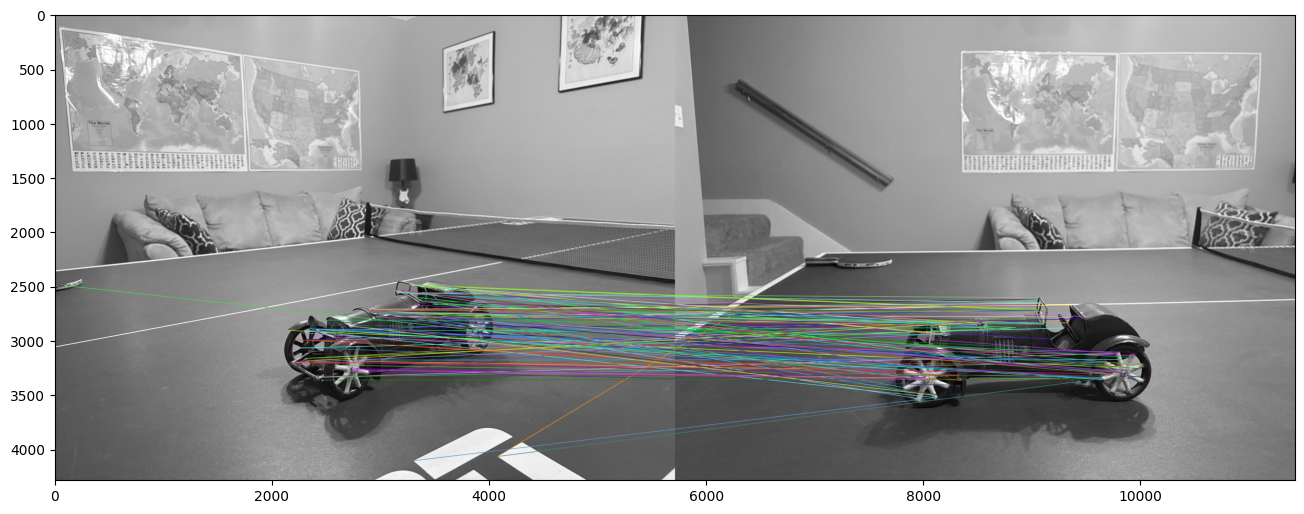

(<Figure size 1600x800 with 1 Axes>,
 None)

In [36]:
orb = cv.ORB_create()
 
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
 
# Match descriptors.
matches = bf.match(des1,des2)
 
# # Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
 
# # Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches,None,matchesThickness=4, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
 
plt.figure(figsize=(16, 8)), plt.imshow(img3),plt.show()

In [17]:
len(pcd2.points)

24470208